In [12]:
import numpy as np
import gym
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta, self.mean, self.std_dev = theta, mean, std_deviation
        self.dt, self.x_initial = dt, x_initial
        self.reset()
    def __call__(self):
        x = (self.x_prev + self.theta * (self.mean - self.x_prev) * self.dt +
             self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape))
        self.x_prev = x
        return x
    def reset(self):
        self.x_prev = self.x_initial if self.x_initial is not None else np.zeros_like(self.mean)

class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        self.buffer_capacity, self.batch_size = buffer_capacity, batch_size
        self.buffer_counter = 0
        self.state_buffer = np.zeros((buffer_capacity, num_states))
        self.action_buffer = np.zeros((buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((buffer_capacity, 1))
        self.next_state_buffer = np.zeros((buffer_capacity, num_states))
    def record(self, obs_tuple):
        index = self.buffer_counter % self.buffer_capacity
        (self.state_buffer[index], self.action_buffer[index],
         self.reward_buffer[index], self.next_state_buffer[index]) = obs_tuple
        self.buffer_counter += 1
    #@tf.function
    def update(self, actor_model, critic_model, target_actor, target_critic, actor_optimizer, critic_optimizer,state_batch, action_batch, reward_batch, next_state_batch):
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * target_critic([next_state_batch, target_actions], training=True)
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.reduce_mean(tf.square(y - critic_value))
        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(zip(critic_grad, critic_model.trainable_variables))
        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            actor_loss = -tf.reduce_mean(critic_value)
        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(zip(actor_grad, actor_model.trainable_variables))
    def learn(self, actor_model, critic_model, target_actor, target_critic,actor_optimizer,critic_optimizer):
        record_range = min(self.buffer_counter, self.buffer_capacity)
        batch_indices = np.random.choice(record_range, self.batch_size)
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.cast(tf.convert_to_tensor(self.reward_buffer[batch_indices]), dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])
        self.update(actor_model, critic_model, target_actor, target_critic,actor_optimizer,critic_optimizer,state_batch, action_batch, reward_batch, next_state_batch)

@tf.function
def update_target(target_weights, weights, tau):
    for a, b in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

def get_actor():
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)
    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model

def get_critic():
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation="relu")(action_input)
    concat = layers.Concatenate()([state_out, action_out])
    out = layers.Dense(256, activation="relu")(concat)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1)(out)
    model = tf.keras.Model([state_input, action_input], outputs)
    return model

def policy(state, noise_object, actor_model, lower_bound, upper_bound):
    sampled_actions = tf.squeeze(actor_model(state))
    noise = noise_object()
    sampled_actions = sampled_actions.numpy() + noise
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)
    return [np.squeeze(legal_action)]

class MultiAgentTradingEnv(gym.Env):
    def __init__(self, db, nsteps):
        self.rnd = 0
        self.lower_bound = 0.0
        self.upper_bound = 1.0
        self.period = -1
        self.nperiods = nperiods
        self.db = db
        self.action_space = gym.spaces.Box(0, 1, (1,), dtype=np.float32)  # Continuous action space [0, 1]
        self.observation_space = gym.spaces.Box(-1, 200, (13,), dtype=np.float32)  # Continuous state space

    def reset(self):
        self.db.reset_period(self.rnd)
        self.timestep = 0
        self.period += 1
        [buyer.next_token() for buyer in self.db.buyers]
        [seller.next_token() for seller in self.db.sellers]
        agent = self.db.buyers[0]
        observation0 = np.array([0, -1, -1, -1, -1, -1, -1, -1, agent.value, -1, -1, -1, agent.num_tokens_traded],dtype=np.float32)
        agent = self.db.buyers[1]
        observation1 = np.array([0, -1, -1, -1, -1, -1, -1, -1, agent.value, -1, -1, -1, agent.num_tokens_traded],dtype=np.float32)
        agent = self.db.sellers[0]
        seller_observation0 = np.array([0, -1, -1, -1, -1, -1, -1, -1, agent.value, -1, -1, -1, agent.num_tokens_traded],dtype=np.float32)
        agent = self.db.sellers[1]
        seller_observation1 = np.array([0, -1, -1, -1, -1, -1, -1, -1, agent.value, -1, -1, -1, agent.num_tokens_traded],dtype=np.float32)
        return [observation0,observation1,seller_observation0,seller_observation1]  # Return continuous state

    def step(self, action0, action1, seller_action0, seller_action1):
        [buyer.next_token() for buyer in self.db.buyers]
        [seller.next_token() for seller in self.db.sellers]
        
        # bidder0
        bid_frac = np.clip(action0, self.lower_bound, self.upper_bound)
        self.db.buyers[0].next_token()
        min_bid = self.db.buyers[0].value * min_frac
        max_bid = self.db.buyers[0].value * max_frac
        bid0 = np.round(max_bid * bid_frac + (1 - bid_frac) * min_bid, 2)

        # bidder1
        bid_frac = np.clip(action1, self.lower_bound, self.upper_bound)
        self.db.buyers[1].next_token()
        min_bid = self.db.buyers[1].value * min_frac
        max_bid = self.db.buyers[1].value * max_frac
        bid1 = np.round(max_bid * bid_frac + (1 - bid_frac) * min_bid, 2)

        # seller0
        ask_frac = np.clip(seller_action0, self.lower_bound, self.upper_bound)
        self.db.sellers[0].next_token()
        min_ask = self.db.sellers[0].value * min_frac
        min_ask = self.db.sellers[0].value * max_frac
        ask0 = np.round(min_ask * ask_frac + (1 - ask_frac) * min_ask, 2)

        # seller0
        ask_frac = np.clip(seller_action1, self.lower_bound, self.upper_bound)
        self.db.sellers[1].next_token()
        min_ask = self.db.sellers[1].value * min_frac
        min_ask = self.db.sellers[1].value * max_frac
        ask1 = np.round(min_ask * ask_frac + (1 - ask_frac) * min_ask, 2)

        # Simulate market
        bids = [buyer.bid(self.db) for buyer in self.db.buyers]
        bids[0] = bid0.item()
        bids[1] = bid1.item()
        asks = [seller.ask(self.db) for seller in self.db.sellers]
        asks[0] = ask0.item()
        asks[1] = ask1.item()
        current_ask, current_ask_idx, current_bid, current_bid_idx = current_bid_ask(bids, asks)
        sale, price, bprofit, sprofit, buy, sell = buy_sell(self.db, current_bid, current_bid_idx, current_ask,
                                                           current_ask_idx)
        step_data = [self.rnd, self.period, self.timestep, bids, asks, current_bid, current_bid_idx, current_ask,
                     current_ask_idx, buy, sell, price, sale, bprofit, sprofit]
        self.db.add_step(step_data)

        # Compute rewards
        reward0 = 0.0
        reward1 = 0.0
        seller_reward0 = 0.0
        seller_reward1 = 0.0
        if sale == 1:
            if current_bid_idx == 0:
                reward0 = bprofit
            if current_bid_idx == 1:
                reward1 = bprofit 
            if current_ask_idx == 0:
                seller_reward0 = sprofit
            if current_ask_idx == 1:
                seller_reward1 = sprofit
                
        # Compute states
        agent = self.db.buyers[0]
        observation0 = np.array([self.timestep + 1, current_ask, current_ask_idx, current_bid, current_bid_idx,
                                sale, price, buy, sell, agent.value, agent.step_profit,
                                agent.sale, agent.num_tokens_traded], dtype=np.float32)
        idx = np.isnan(observation0)
        observation0[idx] = -1.0

        agent = self.db.buyers[1]
        observation1 = np.array([self.timestep + 1, current_ask, current_ask_idx, current_bid, current_bid_idx,
                                sale, price, buy, sell, agent.value, agent.step_profit,
                                agent.sale, agent.num_tokens_traded], dtype=np.float32)
        idx = np.isnan(observation1)
        observation1[idx] = -1.0
        
        agent = self.db.sellers[0]
        seller_observation0 = np.array([self.timestep + 1, current_ask, current_ask_idx, current_bid, current_bid_idx,
                                sale, price, buy, sell, agent.value, agent.step_profit,
                                agent.sale, agent.num_tokens_traded], dtype=np.float32)
        idx = np.isnan(seller_observation0)
        seller_observation0[idx] = -1.0
        
        agent = self.db.sellers[1]
        seller_observation1 = np.array([self.timestep + 1, current_ask, current_ask_idx, current_bid, current_bid_idx,
                                sale, price, buy, sell, agent.value, agent.step_profit,
                                agent.sale, agent.num_tokens_traded], dtype=np.float32)
        idx = np.isnan(seller_observation1)
        seller_observation1[idx] = -1.0
        
        # Check termination
        self.timestep += 1
        terminated = self.timestep == nsteps
        truncated = terminated  # Truncated episodes are not used in DDPG

        return [observation0,observation1,seller_observation0,seller_observation1], [reward0,reward1,seller_reward0,seller_reward1], terminated, {}
                
import numpy as np
from functions import *
from itertools import count
buyer_strategies = ['Honest','Honest']
seller_strategies = ['Honest', 'Honest']
nbuyers, nsellers = len(buyer_strategies), len(seller_strategies)
nrounds, nperiods, ntokens, nsteps, gametype, nbuyers, nsellers = 10, 10, 8, 50, '1234', len(buyer_strategies), len(seller_strategies)
R1, R2, R3, R4 = gametype_to_ran(gametype)
game_metadata = [nrounds, nperiods, ntokens, nbuyers, nsellers, nsteps, R1, R2, R3, R4]
db = Database(game_metadata, buyer_strategies, seller_strategies)
rnd = 0
db.reset_round(rnd, ntokens, nbuyers, nsellers, R1, R2, R3, R4)
period = 0
min_frac = 0.01
max_frac = 1.0
env = MultiAgentTradingEnv(db,nsteps)
num_states, num_actions = env.observation_space.shape[0], env.action_space.shape[0]
upper_bound, lower_bound = env.action_space.high[0], env.action_space.low[0]
num_states = 13

# Common parameters
std_dev = 0.2
total_episodes = 1000
gamma = 0.99
tau = 0.005
critic_lr = 0.002
actor_lr = 0.001
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

# Agent 1
actor_model0 = get_actor()
critic_model0 = get_critic()
target_actor0 = get_actor()
target_critic0 = get_critic()
target_actor0.set_weights(actor_model0.get_weights())
target_critic0.set_weights(critic_model0.get_weights())
critic_optimizer0 = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer0 = tf.keras.optimizers.Adam(actor_lr)
buffer0 = Buffer(50000, 64)
ep_reward_list0, avg_reward_list0 = [], []

# Agent 2
actor_model1 = get_actor()
critic_model1 = get_critic()
target_actor1 = get_actor()
target_critic1 = get_critic()
target_actor1.set_weights(actor_model1.get_weights())
target_critic1.set_weights(critic_model1.get_weights())
critic_optimizer1 = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer1 = tf.keras.optimizers.Adam(actor_lr)
buffer1 = Buffer(50000, 64)
ep_reward_list1, avg_reward_list1 = [], []

# Agent 3 (Seller 1)
seller_actor_model0 = get_actor()
seller_critic_model0 = get_critic()
seller_target_actor0 = get_actor()
seller_target_critic0 = get_critic()
seller_target_actor0.set_weights(seller_actor_model0.get_weights())
seller_target_critic0.set_weights(seller_critic_model0.get_weights())
seller_critic_optimizer0 = tf.keras.optimizers.Adam(critic_lr)
seller_actor_optimizer0 = tf.keras.optimizers.Adam(actor_lr)
seller_buffer0 = Buffer(50000, 64)
seller_ep_reward_list0, seller_avg_reward_list0 = [], []

# Agent 4 (Seller 2)
seller_actor_model1 = get_actor()
seller_critic_model1 = get_critic()
seller_target_actor1 = get_actor()
seller_target_critic1 = get_critic()
seller_target_actor1.set_weights(seller_actor_model1.get_weights())
seller_target_critic1.set_weights(seller_critic_model1.get_weights())
seller_critic_optimizer1 = tf.keras.optimizers.Adam(critic_lr)
seller_actor_optimizer1 = tf.keras.optimizers.Adam(actor_lr)
seller_buffer1 = Buffer(50000, 64)
seller_ep_reward_list1, seller_avg_reward_list1 = [], []

# Training loop for sellers
for ep in range(total_episodes):
    prev_state0, prev_state1, seller_prev_state0, seller_prev_state1 = env.reset()
    episodic_reward0, episodic_reward1, seller_episodic_reward0, seller_episodic_reward1 = 0, 0,0,0

    while True:
        tf_prev_state0 = tf.expand_dims(tf.convert_to_tensor(prev_state0), 0)
        tf_prev_state1 = tf.expand_dims(tf.convert_to_tensor(prev_state1), 0)
        tf_seller_prev_state0 = tf.expand_dims(tf.convert_to_tensor(seller_prev_state0), 0)
        tf_seller_prev_state1 = tf.expand_dims(tf.convert_to_tensor(seller_prev_state1), 0)

        # actions
        action0 = policy(tf_prev_state0, ou_noise, actor_model0, lower_bound, upper_bound)
        action1 = policy(tf_prev_state1, ou_noise, actor_model1, lower_bound, upper_bound)
        seller_action0 = policy(tf_seller_prev_state0, ou_noise, seller_actor_model0, lower_bound, upper_bound)
        seller_action1 = policy(tf_seller_prev_state1, ou_noise, seller_actor_model1, lower_bound, upper_bound)

        # Play game
        [state0, state1, seller_state0, seller_state1], [reward0, reward1, seller_reward0, seller_reward1], done, info = env.step(action0, action1, seller_action0, seller_action1)

        # Record
        buffer0.record((prev_state0, action0, reward0, state0))
        buffer1.record((prev_state1, action1, reward1, state1))
        seller_buffer0.record((prev_state0, seller_action0, seller_reward0, seller_state0))
        seller_buffer1.record((prev_state1, seller_action1, seller_reward1, seller_state1))

        # Episodic rewards
        episodic_reward0 += reward0
        episodic_reward1 += reward1
        seller_episodic_reward0 += seller_reward0
        seller_episodic_reward1 += seller_reward1

        # Training
        buffer0.learn(actor_model0, critic_model0, target_actor0, target_critic0, actor_optimizer0, critic_optimizer0)
        buffer1.learn(actor_model1, critic_model1, target_actor1, target_critic1, actor_optimizer1, critic_optimizer1)
        seller_buffer0.learn(seller_actor_model0,seller_critic_model0,seller_target_actor0,seller_target_critic0,seller_actor_optimizer0,seller_critic_optimizer0,)
        seller_buffer1.learn(seller_actor_model1,seller_critic_model1,seller_target_actor1,seller_target_critic1,seller_actor_optimizer1,seller_critic_optimizer1,)

        # update target
        update_target(target_actor0.variables, actor_model0.variables, tau)
        update_target(target_critic0.variables, critic_model0.variables, tau)
        update_target(target_actor1.variables, actor_model1.variables, tau)
        update_target(target_critic1.variables, critic_model1.variables, tau)
        update_target(seller_target_actor0.variables, seller_actor_model0.variables, tau)
        update_target(seller_target_critic0.variables, seller_critic_model0.variables, tau)
        update_target(seller_target_actor1.variables, seller_actor_model1.variables, tau)
        update_target(seller_target_critic1.variables, seller_critic_model1.variables, tau)

        if done:
            break
        prev_state0 = state0
        prev_state1 = state1
        seller_prev_state0 = seller_state0
        seller_prev_state1 = seller_state1
    
    # avg reward
    ep_reward_list0.append(episodic_reward0)
    ep_reward_list1.append(episodic_reward1)
    seller_ep_reward_list0.append(seller_episodic_reward0)
    seller_ep_reward_list1.append(seller_episodic_reward1)
    avg_reward0 = np.mean(ep_reward_list0[-40:])
    avg_reward1 = np.mean(ep_reward_list1[-40:])
    seller_avg_reward0 = np.mean(seller_ep_reward_list0[-40:])
    seller_avg_reward1 = np.mean(seller_ep_reward_list1[-40:])
    print(
        "Episode * {} * Avg Rewards ==> {}, {}, Sellers' Avg Rewards ==> {}, {}".format(
            ep, np.round(avg_reward0,0), np.round(avg_reward1,0), np.round(seller_avg_reward0,0), np.round(seller_avg_reward1,0)))

plt.plot(avg_reward_list0, label="Buyer 0")
plt.plot(avg_reward_list1, label="Buyer 1")
plt.plot(seller_avg_reward_list0, label="Seller 0")
plt.plot(seller_avg_reward_list1, label="Seller 1")
plt.xlabel("Episode")
plt.ylabel("Avg. Episodic Reward")
plt.legend()
plt.show()

Episode * 0 * Avg Rewards ==> 156.0, 93.0, Sellers' Avg Rewards ==> 21.0, 32.0
Episode * 1 * Avg Rewards ==> 78.0, 98.0, Sellers' Avg Rewards ==> 23.0, 37.0
Episode * 2 * Avg Rewards ==> 86.0, 88.0, Sellers' Avg Rewards ==> 30.0, 53.0
Episode * 3 * Avg Rewards ==> 90.0, 80.0, Sellers' Avg Rewards ==> 37.0, 64.0
Episode * 4 * Avg Rewards ==> 106.0, 81.0, Sellers' Avg Rewards ==> 34.0, 57.0
Episode * 5 * Avg Rewards ==> 111.0, 79.0, Sellers' Avg Rewards ==> 35.0, 59.0
Episode * 6 * Avg Rewards ==> 110.0, 75.0, Sellers' Avg Rewards ==> 39.0, 65.0
Episode * 7 * Avg Rewards ==> 109.0, 73.0, Sellers' Avg Rewards ==> 41.0, 69.0
Episode * 8 * Avg Rewards ==> 108.0, 70.0, Sellers' Avg Rewards ==> 43.0, 72.0
Episode * 9 * Avg Rewards ==> 108.0, 69.0, Sellers' Avg Rewards ==> 45.0, 75.0
Episode * 10 * Avg Rewards ==> 107.0, 67.0, Sellers' Avg Rewards ==> 46.0, 77.0
Episode * 11 * Avg Rewards ==> 107.0, 66.0, Sellers' Avg Rewards ==> 47.0, 78.0
Episode * 12 * Avg Rewards ==> 106.0, 65.0, Sellers' 

KeyboardInterrupt: 

,rnd,period,step,current_bid,current_ask,current_ask_idx,buy,sell,price,sale,bprofit,sprofit
current_bid_idx,,,,,,,,,,,,
0,0,55,637,1598.61,1553.5,14,20,16,882.585,20,532.215,211.385
1,0,445,5488,7308.61,9215.5,90,16,16,652.245,16,407.255,245.245


,rnd,period,step,current_bid,current_ask,current_ask_idx,buy,sell,price,sale,bprofit,sprofit
current_bid_idx,,,,,,,,,,,,
0,0,1125,80,1727.79,743.0,20,25,24,1236.605,25,531.895,493.605
1,0,9995,6045,10293.08,10754.5,5,10,10,519.510,10,275.990,257.010


,rnd,period,step,current_bid,current_bid_idx,current_ask,buy,sell,price,sale,bprofit,sprofit
current_ask_idx,,,,,,,,,,,,
0,0,335,3954,4970.31,123,7024.9,14,12,610.44,14,311.76,169.74
1,0,165,2171,3936.91,90,3744.1,22,20,924.39,22,627.71,286.89


,rnd,period,step,current_bid,current_bid_idx,current_ask,buy,sell,price,sale,bprofit,sprofit
current_ask_idx,,,,,,,,,,,,
0,0,9995,6040,10328.31,220,10737.5,10,10,528.625,10,300.875,283.125
1,0,1125,85,1692.56,5,760.0,25,24,1227.490,25,507.010,467.490


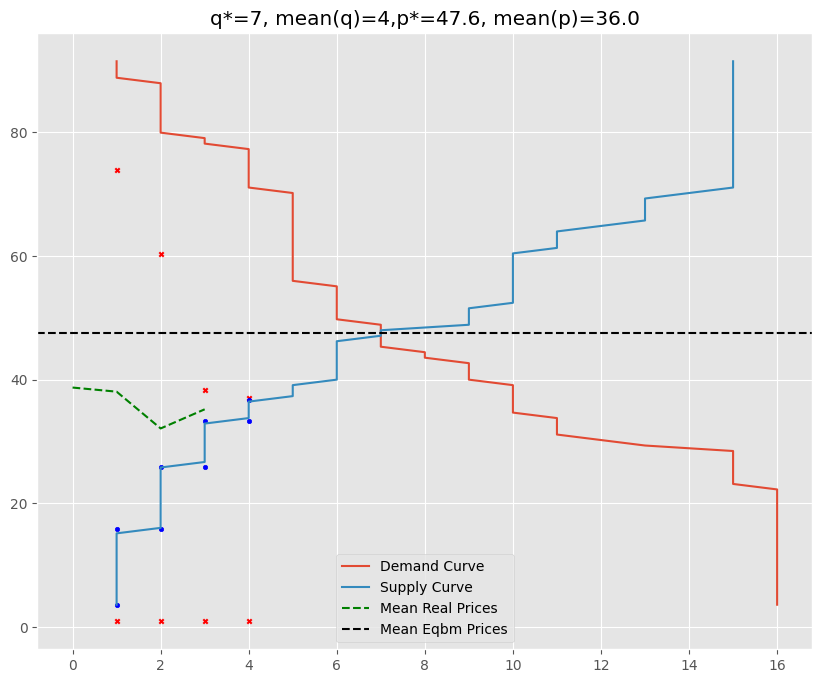

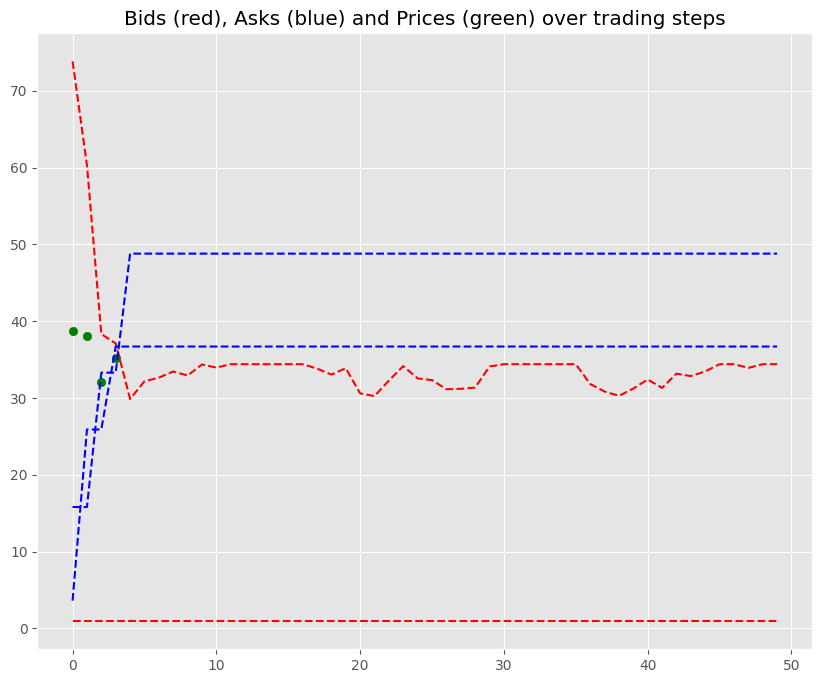

IndexError: list index out of range

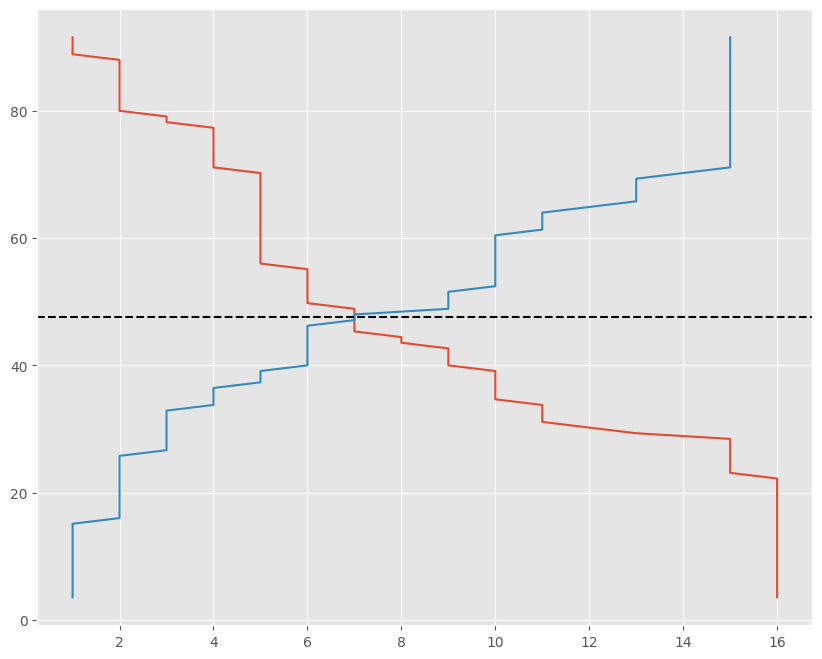

In [13]:
display(db.step_data.head(250).groupby('current_bid_idx').sum())
display(db.step_data.tail(250).groupby('current_bid_idx').sum())
display(db.step_data.head(250).groupby('current_ask_idx').sum())
display(db.step_data.tail(250).groupby('current_ask_idx').sum())
graph_period(env.db, 0, 1)
graph_period(env.db, 0, 45)

In [36]:
env.db.round_data.redemption_values.item()

array([[91.5, 79.9, 77.3, 55.5, 49.5, 39.5, 29. , 22.5],
       [88.6, 70.5, 44.7, 43.3, 34.4, 30.8, 29.8, 28.5]])

In [37]:
env.db.round_data.token_costs.item()

array([[ 15.8,  33.3,  48.8,  48.8,  51.9,  64.5,  64.9,  70.3],
       [  3.6,  25.9,  36.7,  39.4,  46.4,  61.1,  69.5, 103.4]])

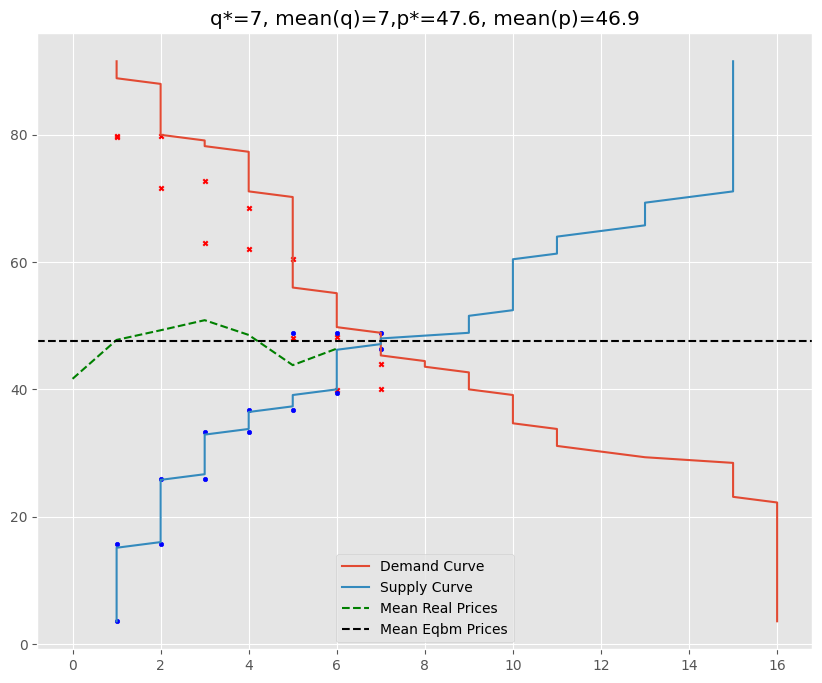

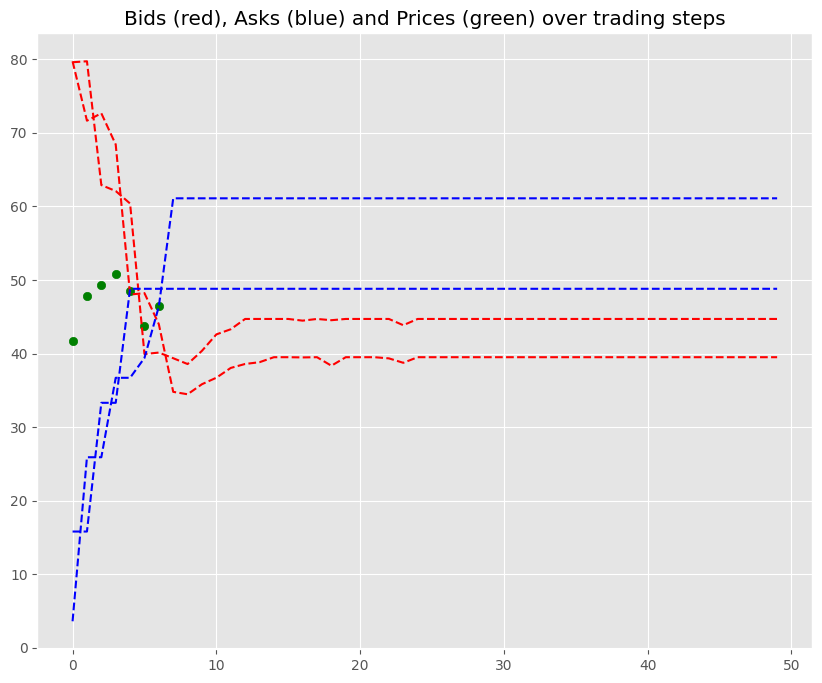

In [38]:
graph_period(env.db, 0, 45)

IndexError: list index out of range

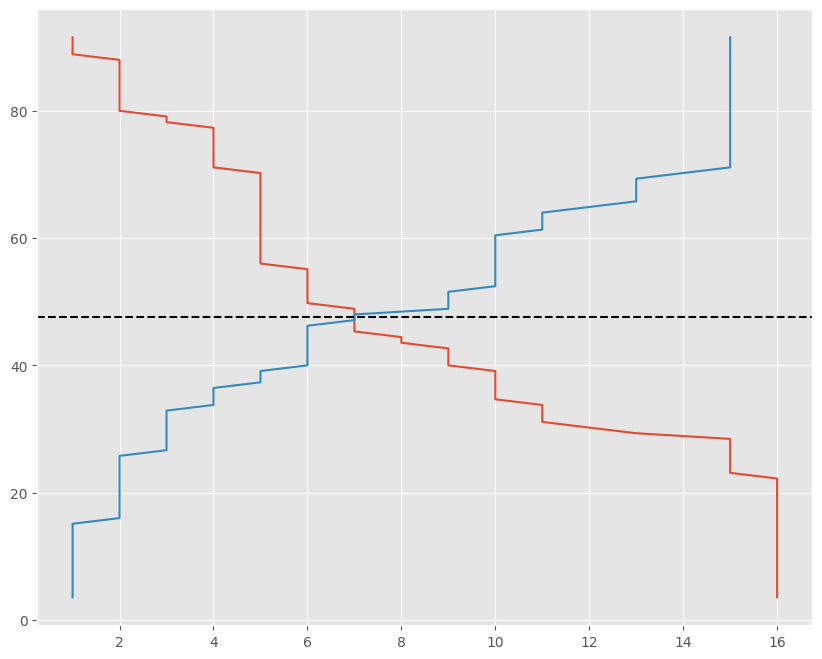

In [35]:
graph_period(env.db, 0, 49)

In [32]:
env.db.step_data.iloc[-74:-25]

,rnd,period,step,bids,asks,current_bid,current_bid_idx,current_ask,current_ask_idx,buy,sell,price,sale,bprofit,sprofit
2300,0,46,0,"[91.5, 88.6]","[15.8, 3.6]",91.50,0,3.6,1,True,True,47.55,1,43.95,43.95
2301,0,46,1,"[79.9, 88.6]","[15.8, 25.9]",88.60,1,15.8,0,True,True,52.20,1,36.40,36.40
2302,0,46,2,"[79.9, 70.5]","[33.3, 25.9]",79.90,0,25.9,1,True,True,52.90,1,27.00,27.00
2303,0,46,3,"[77.3, 70.5]","[33.3, 36.7]",77.30,0,33.3,0,True,True,55.30,1,22.00,22.00
2304,0,46,4,"[55.5, 70.5]","[48.8, 36.7]",70.50,1,36.7,1,True,True,53.60,1,16.90,16.90
2305,0,46,5,"[55.5, 44.7]","[48.8, 39.4]",55.50,0,39.4,1,True,True,47.45,1,8.05,8.05
2306,0,46,6,"[49.5, 44.7]","[48.8, 46.4]",49.50,0,46.4,1,True,True,47.95,1,1.55,1.55
2307,0,46,7,"[39.5, 44.7]","[48.8, 61.1]",44.70,1,48.8,0,False,False,NaN,0,0.00,0.00
2308,0,46,8,"[39.5, 44.7]","[48.8, 61.1]",44.70,1,48.8,0,False,False,NaN,0,0.00,0.00
2309,0,46,9,"[39.5, 44.7]","[48.8, 61.1]",44.70,1,48.8,0,False,False,NaN,0,0.00,0.00


In [26]:
db.round_data.redemption_values.item()

array([[91.5, 79.9, 77.3, 55.5, 49.5, 39.5, 29. , 22.5],
       [88.6, 70.5, 44.7, 43.3, 34.4, 30.8, 29.8, 28.5]])

In [29]:
db.round_data.token_costs.item()

array([[ 15.8,  33.3,  48.8,  48.8,  51.9,  64.5,  64.9,  70.3],
       [  3.6,  25.9,  36.7,  39.4,  46.4,  61.1,  69.5, 103.4]])